In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from discrete_shocklets import shocklets, kernel_functions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

with open("fmri_data.pkl", "rb") as file:
    loaded_list = pickle.load(file)


data = loaded_list
data = data[0] # only first patient - 144, 175, 264

data = np.array(data)
# print(type(data))

print(data.shape) # 175 time step and 264 features


# scale_factor = 1000

# To make the data discrete
# # Use min–max scaling to map the data to integers between 0 and scale_factor.
# scaled_data = np.round((data - data_min) / (data_max - data_min) * scale_factor).astype(int)


(175, 264)


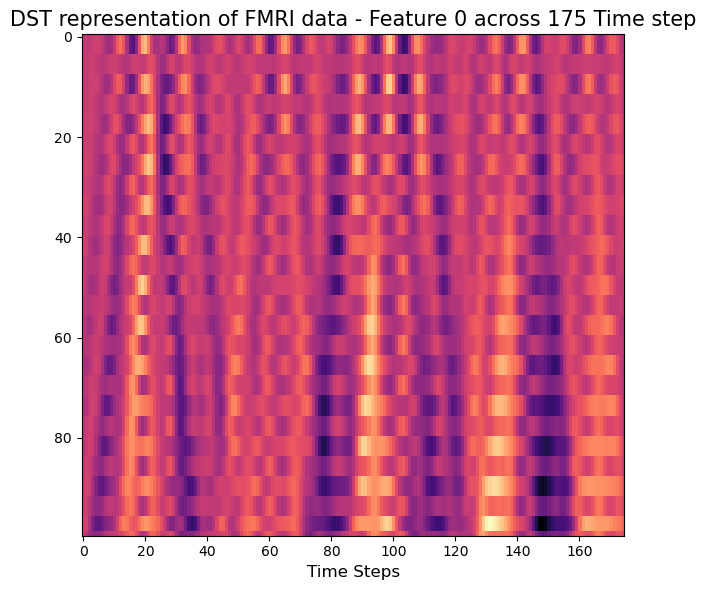

In [5]:
# Due to original model input constriant (only takes 1D time series) - eg. shape : (500,)
# There since fmri data is 2D (140, 264) (time step, features)
# So I mapped it into. Each Image represent all the features of 1 time step.
# So in the end there will be 140 Image.



# Code to generate DST form on FMRI patient 0
windows = np.linspace(10, 175 / 5, 100).astype(int)
kernel = kernel_functions.power_cusp  # a symmetric power-law type cusp
k_args = [1.]  # arguments for the kernel; in this case, it's the parameter $\theta =
reflection = 2  # reflect the kernel over the horizontal axis



x = data.T

x = x[0] # take only the first time step


# 264 175

shocklets_obj = shocklets.cusplet(
    x,
    windows,
    kernel_func=kernel,
    kernel_args=k_args,
    reflection=reflection
)

dst,  largest_kernel = shocklets_obj

# fitting the plot
fig, ax1 = plt.subplots(figsize=(6, 6))

im = ax1.imshow(
    dst,
    aspect='auto',
    cmap=plt.cm.magma,
)

# ON patient 0, time step 1
ax1.set_title('DST representation of FMRI data - Feature 0 across 175 Time step', fontsize=15)
ax1.set_xlabel('Time Steps', fontsize=12)
plt.tight_layout()
plt.savefig('DST_representation_fmri.png')
plt.show()


In [6]:
transposed_data = data.T


In [7]:
# Code to map all the training data for FMRI patient 0. As well as validate the cost of 
# shocklets.cusplet on each time series (row), so each time step will be a shocklet representation with 264 features in it

windows = np.linspace(10, 175 / 5, 100).astype(int)
kernel = kernel_functions.power_cusp  # symmetric power-law type cusp
k_args = [3.]  
reflection = 2  


In [9]:
# Normalize the data to contain only discrete values
# transposed_data = np.round(scaled_data).astype(int)

print(transposed_data)

print(transposed_data.shape)

dst_list = []

# shape : 264, 175

for t in range(transposed_data.shape[0]):  
    x = transposed_data[t]

    # Apply shocklets.cusplet 
    shocklets_obj = shocklets.cusplet(
        x,
        windows,
        kernel_func=kernel,
        kernel_args=k_args,
        reflection=reflection
    )
    
    # Unpack the results
    dst, largest_kernel = shocklets_obj
    
    # Append the DST representation to the list
    dst_list.append((dst, largest_kernel))

print(f"DST representations computed for Where each Feature has its own Time series of 175 time steps. 1 Features taking 1 DST representation")


[[ 0.06064516  0.12524481  0.20088638 ... -0.35865274 -0.12222527
  -0.21767887]
 [ 0.176388   -0.03141484 -0.2517969  ... -1.4569436  -1.0150021
  -0.39216948]
 [ 0.09983223  0.2983658   0.8055868  ... -1.6751657  -1.2115277
  -0.15058891]
 ...
 [ 0.00485292  1.0380265   1.8870571  ... -2.2375107  -1.6083032
  -0.47855434]
 [-0.03812192  1.0973995   1.9859877  ... -1.39907    -0.8827369
  -0.28846744]
 [-0.12440775  1.8594124   3.3355117  ...  1.2627683   1.0283144
  -0.27572992]]
(264, 175)
DST representations computed for Where each Feature has its own Time series of 175 time steps. 1 Features taking 1 DST representation


In [22]:
# empty list to store the reconstructed time series
reconstructed_list = []

# Loop over all DST representations in the dst_list
for dst, largest_kernel in dst_list:
    # Perform the inverse cusplet transformation
    result = shocklets.inverse_cusplet(
        cc=dst,         
        kernel=kernel,  
        widths=windows,
        k_args=k_args,   
        reflection=reflection  
    )
    

    # reconstructed_list.append(result[0]) # only interested in the first element of the result which is the Time Series
    reconstructed_list.append(result[0]) # only interested in the first element of the result which is the Time Series


print(f"Reconstructed {len(reconstructed_list)} time series from the DST representations.")




Reconstructed 264 time series from the DST representations.


In [23]:
# Reshape the reconstructed time series to the original shape of the data
ts_after_model = np.array(reconstructed_list).reshape(264, 175)

# print(ts_after_model)
# print(data.max())


# map back the time series to original scale
reconstructed_data = ts_after_model


mse = mean_squared_error(transposed_data, reconstructed_data)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
mae = mean_absolute_error(transposed_data, reconstructed_data)
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 0.7695846101454937
Mean Absolute Error: 0.5931510601334788
